In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Load the dataset
df = pd.read_csv('data/MAIN.csv')

# Handle missing values (if any)
df = df.dropna()

test_2020_copy = df[df['year'] == 2020].copy()[['year', 'state']]

# Drop the specified string variables
df = df.drop(columns=['proportion_democrat_president', 'state', 'republican_candidate', 'democratic_candidate', 'democratic_candidate_normalized', 'republican_candidate_normalized'])

# Create the final test set for the year 2020
test_2020 = df[df['year'] == 2020]
test_2020_X = test_2020.drop('label', axis=1).values
test_2020_y = test_2020['label'].values.astype(int)  # Ensure labels are integers

# Remove 2020 data from the original dataset to use for training and validation
df = df[df['year'] != 2020]

# Convert categorical variables to dummy/indicator variables (one-hot encoding) if there are any left
df = pd.get_dummies(df)
test_2020 = pd.get_dummies(test_2020)

# Ensure both train and test sets have the same columns after one-hot encoding
df, test_2020 = df.align(test_2020, join='left', axis=1, fill_value=0)

# Split into features and target
X = df.drop('label', axis=1).values
y = df['label'].values.astype(int)  # Ensure labels are integers

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_2020_X = scaler.transform(test_2020_X)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)  # NLLLoss expects long type for labels
test_2020_X = torch.tensor(test_2020_X, dtype=torch.float32)
test_2020_y = torch.tensor(test_2020_y, dtype=torch.long)  # NLLLoss expects long type for labels

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
test_2020_dataset = TensorDataset(test_2020_X, test_2020_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_2020_loader = DataLoader(test_2020_dataset, batch_size=32, shuffle=False)

input_dim = X.shape[1]
num_classes = len(torch.unique(y))  # Determine the number of classes


The input dimension is: 9
The number of classes is: 2


In [62]:


# Define the ClassificationModel
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.log_softmax(x)
        return x

# Initialize the model, loss function, and optimizer
model = ClassificationModel(input_dim, 2)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [63]:

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.1488
Epoch [2/100], Loss: 0.9932
Epoch [3/100], Loss: 0.8549
Epoch [4/100], Loss: 1.2050
Epoch [5/100], Loss: 0.9879
Epoch [6/100], Loss: 0.9123
Epoch [7/100], Loss: 1.1368
Epoch [8/100], Loss: 0.8140
Epoch [9/100], Loss: 0.7196
Epoch [10/100], Loss: 0.7141
Epoch [11/100], Loss: 0.9302
Epoch [12/100], Loss: 0.7342
Epoch [13/100], Loss: 0.6206
Epoch [14/100], Loss: 0.7019
Epoch [15/100], Loss: 0.5945
Epoch [16/100], Loss: 0.6552
Epoch [17/100], Loss: 0.5397
Epoch [18/100], Loss: 0.5514
Epoch [19/100], Loss: 0.5793
Epoch [20/100], Loss: 0.6011
Epoch [21/100], Loss: 0.5279
Epoch [22/100], Loss: 0.4454
Epoch [23/100], Loss: 0.5588
Epoch [24/100], Loss: 0.5442
Epoch [25/100], Loss: 0.4666
Epoch [26/100], Loss: 0.5454
Epoch [27/100], Loss: 0.5124
Epoch [28/100], Loss: 0.4455
Epoch [29/100], Loss: 0.4544
Epoch [30/100], Loss: 0.4128
Epoch [31/100], Loss: 0.4772
Epoch [32/100], Loss: 0.4290
Epoch [33/100], Loss: 0.6021
Epoch [34/100], Loss: 0.3423
Epoch [35/100], Loss: 0

In [64]:
model.eval()
with torch.no_grad():
    test_losses = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_losses.append(loss.item())

    print(f'Average Test Loss: {sum(test_losses)/len(test_losses):.4f}')

    # Evaluate on the 2020 test set
    test_2020_losses = []
    for batch_X, batch_y in test_2020_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_2020_losses.append(loss.item())

    print(f'Average Test Loss for 2020: {sum(test_2020_losses)/len(test_2020_losses):.4f}')


Average Test Loss: 0.3704
Average Test Loss for 2020: 0.1994


In [65]:
# Predict on the 2020 test set
model.eval()
with torch.no_grad():
    predictions = []
    probabilities = []
    for batch_X, _ in test_2020_loader:
        outputs = model(batch_X)
        probs = torch.exp(outputs)  # Since we used LogSoftmax, we apply exp to get probabilities
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (0 or 1)
        predictions.extend(predicted.numpy())
        probabilities.extend(probs.numpy()[:, 1])  # Assuming class 1 is the Democratic candidate

# Convert predictions and probabilities to a DataFrame for easier viewing
predictions_df = pd.DataFrame({
    'predicted_class': predictions,
    'implied_probability': probabilities
})
test_2020_copy.reset_index(drop=True, inplace=True)
result_df = pd.concat([test_2020_copy, predictions_df], axis=1)

# Electoral votes per state
electoral_votes = {
    "ALABAMA": 9,
    "ALASKA": 3,
    "ARIZONA": 11,
    "ARKANSAS": 6,
    "CALIFORNIA": 55,
    "COLORADO": 9,
    "CONNECTICUT": 7,
    "DELAWARE": 3,
    "DISTRICT OF COLUMBIA": 3,
    "FLORIDA": 29,
    "GEORGIA": 16,
    "HAWAII": 4,
    "IDAHO": 4,
    "ILLINOIS": 20,
    "INDIANA": 11,
    "IOWA": 6,
    "KANSAS": 6,
    "KENTUCKY": 8,
    "LOUISIANA": 8,
    "MAINE": 4,
    "MARYLAND": 10,
    "MASSACHUSETTS": 11,
    "MICHIGAN": 16,
    "MINNESOTA": 10,
    "MISSISSIPPI": 6,
    "MISSOURI": 10,
    "MONTANA": 3,
    "NEBRASKA": 5,
    "NEVADA": 6,
    "NEW HAMPSHIRE": 4,
    "NEW JERSEY": 14,
    "NEW MEXICO": 5,
    "NEW YORK": 29,
    "NORTH CAROLINA": 15,
    "NORTH DAKOTA": 3,
    "OHIO": 18,
    "OKLAHOMA": 7,
    "OREGON": 7,
    "PENNSYLVANIA": 20,
    "RHODE ISLAND": 4,
    "SOUTH CAROLINA": 9,
    "SOUTH DAKOTA": 3,
    "TENNESSEE": 11,
    "TEXAS": 38,
    "UTAH": 6,
    "VERMONT": 3,
    "VIRGINIA": 13,
    "WASHINGTON": 12,
    "WEST VIRGINIA": 5,
    "WISCONSIN": 10,
    "WYOMING": 3
}

# Add electoral votes to the result DataFrame
result_df['electoral_votes'] = result_df['state'].apply(lambda x: electoral_votes[x.upper()])

# Calculate the total electoral votes for the Democratic candidate
result_df['democratic_votes'] = result_df.apply(lambda row: row['electoral_votes'] if row['predicted_class'] == 1 else 0, axis=1)
total_democratic_votes = result_df['democratic_votes'].sum()

# Calculate the total electoral votes for the Republican candidate
total_republican_votes = 538 - total_democratic_votes

# Print the results
print(result_df)
print(f'Model expected outcome: Biden: {int(total_democratic_votes)}, Trump: {538 - int(total_democratic_votes)}')
print('True outcome: Biden: 306, Trump: 232')

    year                 state  predicted_class  implied_probability  \
0   2020               ALABAMA                0             0.052800   
1   2020                ALASKA                0             0.082699   
2   2020               ARIZONA                0             0.399308   
3   2020              ARKANSAS                0             0.042603   
4   2020            CALIFORNIA                1             0.963627   
5   2020              COLORADO                1             0.740740   
6   2020           CONNECTICUT                1             0.970308   
7   2020              DELAWARE                1             0.973516   
8   2020  DISTRICT OF COLUMBIA                1             0.999994   
9   2020               FLORIDA                1             0.631787   
10  2020               GEORGIA                0             0.495052   
11  2020                HAWAII                1             0.996995   
12  2020                 IDAHO                0             0.02

Assuming all state outcomes are independently distributed, I will now simulate the probability that the Democratic party would win the 2020 election.

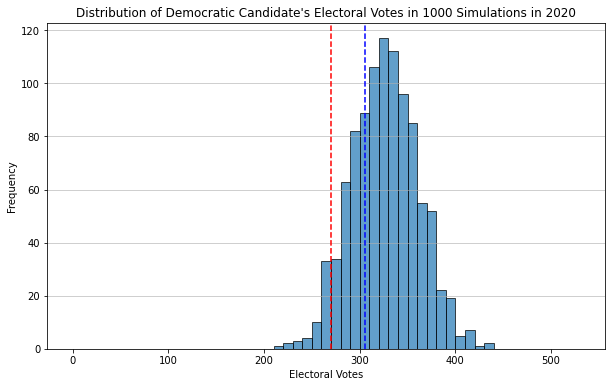

Estimated probability of a Republican win: 0.0530
Estimated probability of a Democratic win: 0.9470


In [68]:
# Add electoral votes to the result DataFrame
result_df['electoral_votes'] = result_df['state'].apply(lambda x: electoral_votes[x.upper()])

# Simulation to estimate the probability of Democrats winning
num_simulations = 1000
democratic_votes_list = []

for _ in range(num_simulations):
    total_democratic_votes = 0
    for _, row in result_df.iterrows():
        random_number = np.random.uniform(0, 1)
        if random_number < row['implied_probability']:
            total_democratic_votes += row['electoral_votes']
    democratic_votes_list.append(total_democratic_votes)

# Plot the Democratic candidate's votes in each simulation
plt.figure(figsize=(10, 6))
plt.hist(democratic_votes_list, bins=range(0, 540, 10), edgecolor='black', alpha=0.7)
plt.axvline(x=270, color='r', linestyle='--', label='270 Electoral Votes (Win Threshold)')
plt.axvline(x=306, color='b', linestyle='--', label='306 Electoral Votes (Actual Result)')
plt.title('Distribution of Democratic Candidate\'s Electoral Votes in 1000 Simulations in 2020')
plt.xlabel('Electoral Votes')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calculate the probability of a Democratic win
democratic_wins = sum(votes >= 270 for votes in democratic_votes_list)
democratic_win_probability = democratic_wins / num_simulations

print(f'Estimated probability of a Republican win: {1 - democratic_win_probability:.4f}')
print(f'Estimated probability of a Democratic win: {democratic_win_probability:.4f}')

However, the states are not independently distributed. For example, this simulation considers there to be around a .05% probability that Massachusetts goes red and Alabama goes blue, which is almost certainly an overestimate. For a more somewhat realistic simulation, I'll assume that if any state with probability <.2 of being won by the democrats goes blue, then all states with probability >.5 of going blue will also go blue with probability 1. Similarly, if any state with probability >.8 of being won by the democrats goes red, then all states with probability <.5 of going blue will go red with probability 1.  

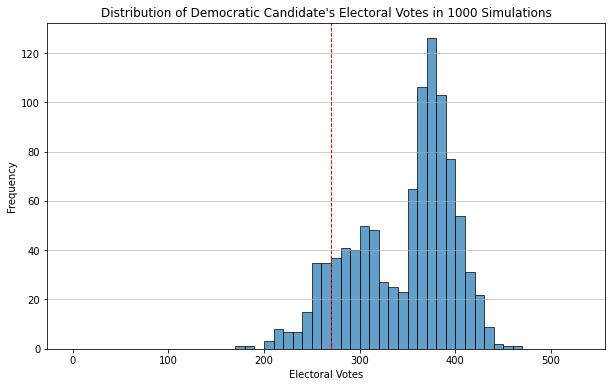

Estimated probability of a Democratic win: 0.8880


In [71]:
# Simulation to estimate the probability of Democrats winning
num_simulations = 1000
democratic_votes_list = []

for _ in range(num_simulations):
    total_democratic_votes = 0
    state_results = []

    for _, row in result_df.iterrows():
        random_number = np.random.uniform(0, 1)
        state_results.append((random_number, row))

    any_below_20_blue = False
    any_above_80_red = False

    for random_number, row in state_results:
        if random_number < row['implied_probability'] and row['implied_probability'] < 0.2 and not any_above_80_red:
            any_below_20_blue = True
            break
        elif random_number > row['implied_probability'] and row['implied_probability'] > 0.8 and not any_below_20_blue:
            any_above_80_red = True
            break

    for random_number, row in state_results:
        if any_below_20_blue and not any_above_80_red:
            if row['implied_probability'] > 0.5:
                total_democratic_votes += row['electoral_votes']
            elif random_number < row['implied_probability']:
                total_democratic_votes += row['electoral_votes']
        elif any_above_80_red and not any_below_20_blue:
            if row['implied_probability'] < 0.5:
                continue
            elif random_number < row['implied_probability']:
                total_democratic_votes += row['electoral_votes']
        else:
            if random_number < row['implied_probability']:
                total_democratic_votes += row['electoral_votes']

    democratic_votes_list.append(total_democratic_votes)

# Plot the Democratic candidate's votes in each simulation
plt.figure(figsize=(10, 6))
plt.hist(democratic_votes_list, bins=range(0, 540, 10), edgecolor='black', alpha=0.7)
plt.axvline(x=270, color='r', linestyle='--', linewidth=1)
plt.title('Distribution of Democratic Candidate\'s Electoral Votes in 1000 Simulations')
plt.xlabel('Electoral Votes')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calculate the probability of a Democratic win
democratic_wins = sum(votes >= 270 for votes in democratic_votes_list)
democratic_win_probability = democratic_wins / num_simulations

print(f'Estimated probability of a Democratic win: {democratic_win_probability:.4f}')